In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

from sklearn.metrics import confusion_matrix as conf_mat

%pylab inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
%load_ext watermark

Populating the interactive namespace from numpy and matplotlib


In [2]:
%watermark -v -m -p numpy,pandas,seaborn,pymc3,matplotlib

CPython 3.5.2
IPython 6.0.0

numpy 1.12.1
pandas 0.20.1
seaborn 0.7.1
pymc3 3.1rc3
matplotlib 2.0.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-77-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Table of Content
[Abstract](#Abstract)  
[Experiment info](#Experiment-information-snippet)  

Load data
- [Display one subject](#Display-one-subject)  
- [Load all data](#Load-all-subject)  
- [Data filtering](#Data-Filtering)  

[Descriptive result](#Display-descriptive-result-by-age-group)  
- [Confusion Matrix](#mean-confusion-matrix)  
- [Expression recognition as the function of age](#Lineplot-of-accurate-recognition-as-a-function-of-age)  
- [Dynamic advantage](#Dynamic-advantage-as-a-function-of-age)  

[Display Raw](#Display-Raw)  

[Piece-wise regression model](#Facial-expression-recognition-as-a-function-of-age)  
- [Full model for fitting all task together](#Full-model-for-fitting-all-task-together)
- [Setup helper function for PyMC3](#Setup-helper-function-for-PyMC3)   
- [Anger](#Anger)  
- [Disgust](#Disgust)  
- [Fear](#Fear)  
- [Happy](#Happy)  
- [Sad](#Sad)    
- [Surprise](#Surprise)  

# Tracking the recognition of static and dynamic facial expressions of emotion across life span

Anne-Raphaëlle Richoz<sup>1</sup>, Junpeng Lao<sup>1</sup>, Olivier Pascalis<sup>2</sup>, and Roberto Caldara<sup>1</sup>  
*<sup>1</sup>Eye and Brain Mapping Laboratory (iBMLab), Department of Psychology, University of Fribourg, Fribourg, Switzerland*  
*<sup>2</sup>Laboratoire de Psychologie et Neurocognition (CNRS), Université Grenoble-Alpes, Grenoble, France*


## Abstract  
Dynamic social signals are steadily stimulating the visual system during human interactions. A wealth of such signals are transmitted as facial expressions for communicating internal emotional states. Unlike static snapshots, routinely used in most of the experiments, dynamic facial expressions provide observers with richer and ecologically-valid signals. Common intuition would thus suggest an advantage for the recognition of dynamic over static inputs. However, while many studies reported an advantage in the recognition of dynamic over static expressions in clinical populations ([Richoz et al., 2015](http://perso.unifr.ch/roberto.caldara/pdfs/richoz_15.pdf)), results obtained with healthy young adults are by far more contrasted. To clarify this issue, we conducted a large sample cross-sectional study to investigate facial expression recognition from early to elderly age. Over 400 observers (age range 5-100) performed recognition tasks of the six basic expressions in three conditions: static, shuffled (temporally randomized frames) and dynamic ([Gold et al., 2013](https://dx.doi.org/10.1167%2F13.5.23)). We normalized the stimuli for their low-level properties and the amount of energy sampled over time, even for the static condition. Facial expression recognition profiles revealed a better performance for “happy” and typical confusions among expressions with similar morphology (fear-surprise), regardless of condition and age. We then applied a Generalized Additive Model with smoothing spline on an efficiency index to capture the nonlinear relationship between age and the experimental conditions. Overall, we observed strong efficiency in the recognition of dynamic facial expressions in the elderly population. This observation was driven by a suboptimal performance for static and shuffled expressions, a potential marker for impaired face processing that might be linked to other facets of general cognitive decline. Our findings also posit the use of dynamic stimuli as being critical in the assessment of facial expression recognition in elderly populations, inviting to caution when drawing conclusions from the sole use of static face images to this aim.

## Experiment information snippet

### Experiment setup
Participant perform 3 different task [Dynamic,Shuffl,Static], each with 96 trials (2 sex x 6 expression x 4 identities x 2 repetition)

### Stimuli (static)

![fig1](figs/img1.jpg)

## Display one subject

In [3]:
proj_path = '/home/laoj/Documents/Github/Static_dynamic'
datatmp = pd.read_csv(proj_path + '/data/CHuguet_g1_a9_DyExp_beh.txt','\t',
                      header=None)
# change column name
column_name = ['Trial','Resp','ACC','RT','cRect1','cRect2','cRect3','cRect4',
               'Randseq','Task']
datatmp.columns=column_name
# change stimuli name
stim_list = pd.read_csv(proj_path + '/experiment_code/stimuli_list.csv',',')
datatmp['Expression'] = np.asarray(stim_list['Expression'].loc[datatmp['Randseq']-1])
# change response name
resp_list = np.asarray(['Fear','Anger','Disgust','Happiness','Sadness','Surprise'])
Resp = []
for iresp in datatmp['Resp']:
    if np.isfinite(iresp):
        Resp.append(resp_list[int(iresp-1)])
    else:
        Resp.append(np.nan)
datatmp['Resp_Exp'] = np.asarray(Resp)
# change task name
Taskname = np.asarray(['Dynamic','Shuffled','Static'])
datatmp['Task_nam'] = Taskname[datatmp['Task']-1]
# show dataframe (first 5 lines)
datatmp.head(5)

,Trial,Resp,ACC,RT,cRect1,cRect2,cRect3,cRect4,Randseq,Task,Expression,Resp_Exp,Task_nam
0,1,3.0,1.0,3.469837,340.5176,70.51765,1099.482,829.4824,64,1,Disgust,Disgust,Dynamic
1,2,5.0,0.0,1.791639,340.5176,70.51765,1099.482,829.4824,12,1,Disgust,Sadness,Dynamic
2,3,2.0,0.0,4.039435,340.5176,70.51765,1099.482,829.4824,13,1,Disgust,Anger,Dynamic
3,4,5.0,1.0,4.190567,340.5176,70.51765,1099.482,829.4824,87,1,Sadness,Sadness,Dynamic
4,5,2.0,1.0,1.299397,340.5176,70.51765,1099.482,829.4824,54,1,Anger,Anger,Dynamic


In [4]:
taskorder = datatmp.Task.unique() - 1
print('The task order is:' + str(taskorder))

labellist = np.asarray(['Anger','Disgust','Fear','Happiness','Sadness','Surprise'])
for ij,itask in enumerate(Taskname):
    datatask  = datatmp[datatmp['Task_nam']==itask]
    conf_subj = conf_mat(datatask['Expression'],datatask['Resp_Exp'],labels=labellist)
    conf_df = pd.DataFrame(conf_subj,columns=labellist,index=labellist)
    conf_df['trials']=datatask['Expression'].value_counts()
    print('\n'+itask)
    print(conf_df)

The task order is:[0 2 1]

Dynamic
           Anger  Disgust  Fear  Happiness  Sadness  Surprise  trials
Anger          9        3     2          0        2         0      16
Disgust        6        5     2          0        3         0      16
Fear           0        1     3          0        3         8      16
Happiness      0        0     0         16        0         0      16
Sadness        2        2     0          0       11         1      16
Surprise       0        0     0          2        0        14      16

Shuffled
           Anger  Disgust  Fear  Happiness  Sadness  Surprise  trials
Anger         12        3     0          0        1         0      16
Disgust        9        4     2          0        0         0      16
Fear           1        3     5          0        1         6      16
Happiness      0        0     0         14        0         0      16
Sadness        3        1     2          0        7         1      16
Surprise       0        1     2          4   

Define a function for loading each subject.

In [5]:
def loadsbj(filepath,labellist,column_name,stim_list,Taskname):
    datatmp = pd.read_csv(filepath,'\t',
                          header=None)
    # change column name
    datatmp.columns=column_name
    # change stimuli name
    datatmp['Expression'] = np.asarray(stim_list['Expression'].loc[datatmp['Randseq']-1])
    # change response name
    Resp = []
    for iresp in datatmp['Resp']:
        if np.isfinite(iresp):
            Resp.append(resp_list[int(iresp-1)])
        else:
            Resp.append(np.nan)
    datatmp['Resp_Exp'] = np.asarray(Resp)
    # change task name
    datatmp['Task_nam'] = Taskname[datatmp['Task']-1]
    taskorder = datatmp.Task.unique() - 1
    conf_all = np.zeros((3,len(labellist),len(labellist)+1))
    for ij,itask in enumerate(Taskname):
        datatask  = datatmp[datatmp['Task_nam']==itask]
        if datatask.shape[0]>0:
            conf_subj = conf_mat(datatask['Expression'],datatask['Resp_Exp'],labels=labellist)
            conf_df = pd.DataFrame(conf_subj,columns=labellist,index=labellist)
            conf_df['trials']=datatask['Expression'].value_counts()
            conf_all[ij]=np.asarray(conf_df)
        
    return taskorder,np.asarray(conf_all)

Taskname = np.asarray(['Dynamic','Shuffled','Static'])
resp_list = np.asarray(['Fear','Anger','Disgust','Happiness','Sadness','Surprise'])
column_name = ['Trial','Resp','ACC','RT','cRect1','cRect2','cRect3','cRect4',
                   'Randseq','Task']
stim_list = pd.read_csv(proj_path + '/experiment_code/stimuli_list.csv',',')
labellist = np.asarray(['Anger','Disgust','Fear','Happiness','Sadness','Surprise'])

filepath = proj_path + '/data/CHuguet_g1_a9_DyExp_beh.txt'
taskorder,conf_all = loadsbj(filepath,labellist,column_name,stim_list,Taskname)
print(taskorder)
print(conf_all)

[0 2 1]
[[[  9.   3.   2.   0.   2.   0.  16.]
  [  6.   5.   2.   0.   3.   0.  16.]
  [  0.   1.   3.   0.   3.   8.  16.]
  [  0.   0.   0.  16.   0.   0.  16.]
  [  2.   2.   0.   0.  11.   1.  16.]
  [  0.   0.   0.   2.   0.  14.  16.]]

 [[ 12.   3.   0.   0.   1.   0.  16.]
  [  9.   4.   2.   0.   0.   0.  16.]
  [  1.   3.   5.   0.   1.   6.  16.]
  [  0.   0.   0.  14.   0.   0.  16.]
  [  3.   1.   2.   0.   7.   1.  16.]
  [  0.   1.   2.   4.   0.   8.  16.]]

 [[ 11.   3.   0.   0.   2.   0.  16.]
  [  5.   8.   2.   0.   1.   0.  16.]
  [  4.   2.   3.   0.   1.   6.  16.]
  [  0.   0.   0.  15.   0.   0.  16.]
  [  3.   1.   1.   0.   8.   2.  16.]
  [  0.   0.   0.   4.   0.  12.  16.]]]


# Load all subject

In [6]:
Sbjall_txt = os.listdir(proj_path+'/data/')
gender = []
age = []
sbjname = []
confusionall = []
taskorderall = []
for string in Sbjall_txt:
    info = string.split(sep='_')
    gender.append(int(info[1][1:]))
    age.append(int(info[2][1:]))
    sbjname.append(info[0])
    filepath = proj_path + '/data/' + string
    taskorder,conf_all = loadsbj(filepath,labellist,column_name,stim_list,Taskname)
    confusionall.append(conf_all)
    taskorderall.append(taskorder)

In [7]:
subject_info = pd.DataFrame({'name': sbjname, 'gender': gender, 'age': age, 'taskorder':taskorderall})
confusionall = np.asarray(confusionall)
print(subject_info.head(5))
print(confusionall.shape)
print(subject_info.shape)

   age  gender           name  taskorder
0   84       1  SCudreMauroux  [0, 2, 1]
1   15       2     PaNydegger  [2, 1, 0]
2   14       1        ASelimi  [1, 0, 2]
3   93       1          MMusy  [0, 1, 2]
4    5       2         FAdamo  [2, 0, 1]
(444, 3, 6, 7)
(444, 4)


# Data Filtering
There are some subject that did not answer one expression on the first task. Because we do not know whether they actually did not perceive that expression or did not understand the task, we excluded these subjects from the analysis.  
If subjects did not answer one expression on the second or third task, but did so on the first one, they were included in the analysis as we assumed they understood correctly the instructions.  

In [8]:
nsbj = subject_info.shape[0]
subject_info['exclude'] = np.zeros(nsbj)
for isbj, taskorder, confmat in zip(range(nsbj),subject_info['taskorder'],confusionall):
    emptyresp = np.where(np.sum(confmat[taskorder[0]],axis=0)[:6]==0)
    if emptyresp[0].size!=0:
        print('Sbj ' +str(isbj) + ' missing expression ' + str(labellist[emptyresp[0]]))
        subject_info.loc[isbj,('exclude')]=1

Sbj 23 missing expression ['Fear']
Sbj 25 missing expression ['Surprise']
Sbj 66 missing expression ['Anger']
Sbj 104 missing expression ['Fear']
Sbj 105 missing expression ['Fear']
Sbj 147 missing expression ['Fear']
Sbj 152 missing expression ['Disgust']
Sbj 173 missing expression ['Surprise']
Sbj 192 missing expression ['Fear']
Sbj 195 missing expression ['Disgust']
Sbj 210 missing expression ['Disgust']
Sbj 234 missing expression ['Fear']
Sbj 253 missing expression ['Anger']
Sbj 295 missing expression ['Disgust']
Sbj 297 missing expression ['Disgust' 'Fear']
Sbj 303 missing expression ['Fear']
Sbj 304 missing expression ['Fear']
Sbj 314 missing expression ['Fear']
Sbj 316 missing expression ['Surprise']
Sbj 324 missing expression ['Fear']
Sbj 347 missing expression ['Fear']
Sbj 383 missing expression ['Surprise']
Sbj 385 missing expression ['Sadness']
Sbj 392 missing expression ['Surprise']
Sbj 407 missing expression ['Disgust']
Sbj 415 missing expression ['Fear']
Sbj 420 missing e

Output desciptive table for the valid subject

In [9]:
# print(subject_info.loc[subject_info['exclude']==1])
include = subject_info['exclude']==0
Info_tbl = pd.DataFrame.copy(subject_info.loc[include]).reset_index()
Conf_mat = confusionall[include,:,:,:]
gendervec = np.asarray(Info_tbl['gender']) - 1
Info_tbl['gender'] = pd.Categorical.from_codes(gendervec, categories=["female", "male"])

print('The total sample size is: '+ str(Info_tbl.shape[0]))
bins = [4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 100]
group_names = ['a05-06', 'a07-08', 'a09-10', 'a11-12', 'a13-14', 'a15-16',
               'a17-18', 'a19-20', 'a21-30', 'a31-40', 'a41-50', 'a51-60',
               'a61-70', 'a71-80', 'a81-99']
group_order = np.arange(0,len(bins)-1)
Info_tbl['age_group'] = pd.cut(Info_tbl['age'], bins, labels=group_names)
Info_tbl['age_group2'] = pd.cut(Info_tbl['age'], bins, labels=group_order)
Info_tbl['age_mean'] = np.zeros((len(Info_tbl)))
for iage in Info_tbl['age_group'].unique():
    idex = Info_tbl['age_group']==iage
    Info_tbl.loc[idex,('age_mean')] = np.mean(Info_tbl['age'][idex])

print('\nNumber of subject per age group:')
Descriptive1 = pd.DataFrame({'Num_sbj':Info_tbl.groupby(['age_group']).size()}).reset_index()
print(Descriptive1)
Descriptive2 = pd.DataFrame({'Num_sbj':Info_tbl.groupby(['age_group','gender']).size()}).reset_index()
print('\nNumber of subject per age group (by gender):')
print(Descriptive2)

The total sample size is: 412

Number of subject per age group:
   age_group  Num_sbj
0     a05-06       27
1     a07-08       24
2     a09-10       22
3     a11-12       22
4     a13-14       24
5     a15-16       21
6     a17-18       21
7     a19-20       31
8     a21-30       31
9     a31-40       23
10    a41-50       33
11    a51-60       30
12    a61-70       32
13    a71-80       31
14    a81-99       40

Number of subject per age group (by gender):
   age_group  gender  Num_sbj
0     a05-06  female       17
1     a05-06    male       10
2     a07-08  female       17
3     a07-08    male        7
4     a09-10  female       11
5     a09-10    male       11
6     a11-12  female       14
7     a11-12    male        8
8     a13-14  female       10
9     a13-14    male       14
10    a15-16  female        8
11    a15-16    male       13
12    a17-18  female       16
13    a17-18    male        5
14    a19-20  female       27
15    a19-20    male        4
16    a21-30  female       2

In [42]:
import pickle
temp = {'Conf_mat': Conf_mat, 'Info_tbl':Info_tbl}
with open('temp.pickle', 'wb') as f:
    pickle.dump(temp, f)

# Display descriptive result by age group
### mean confusion matrix

In [10]:
exp_list  = np.asarray(['Anger','Disgust','Fear','Happy','Sad','Surprise'])
resp_list = np.asarray(['Anger','Disgust','Fear','Happy','Sad','Surprise','Null'])
Tasksel = ['Dynamic', 'Static', 'Shuffled']

In [11]:
for iage, tblage in Info_tbl.groupby('age_group'):
    Conftmp = Conf_mat[tblage.index,:,:,:6]
    Conftrl = Conf_mat[tblage.index,:,:,6]
    tmp = Conftrl-np.sum(Conftmp,axis=3)
    Conftmp2 = np.concatenate((Conftmp,np.expand_dims(tmp,axis=3)),axis=3)
    trialnum = np.reshape(np.repeat(Conftrl,7,axis=2),newshape=Conftmp2.shape)
    Confgroup = Conftmp2/trialnum
    if sum(Confgroup>1)>0:
        print('Error at group '+str(iage))
    for ij,itask in enumerate(Tasksel):
        idx = np.where(Taskname == itask)[0][0]
        mattmp  = Confgroup[:,idx,:,:]
        meanmat = np.mean(mattmp[np.isfinite(mattmp[:,0,0]),:,:],axis=0)
        conf_mean = pd.DataFrame(meanmat,columns=resp_list,index=exp_list)

### Lineplot of accurate recognition as a function of age
It is the same as displaying the diagonal of the confusion matrix

In [12]:
Conftmp = Conf_mat[:,:,:,:6]
# NaN response as ignore
# Conftrl = np.sum(Conftmp,axis=3)
# trialnum = np.reshape(np.repeat(Conftrl,6,axis=2),newshape=Conftmp.shape)
# NaN response as incorrect
trialnum = np.reshape(np.repeat(Conf_mat[:,:,:,6],6,axis=2),newshape=Conftmp.shape)
Confmean = Conftmp/trialnum

In [13]:
itask = 'Dynamic'
print('Displaying '+str(itask)+' condition')
idx = np.where(Taskname == itask)[0][0]
mattmp  = Confmean[:,idx,:,:]

datatbl1 = pd.DataFrame.copy(Info_tbl)
for ic, emolabel in enumerate(exp_list):
    datatbl1[emolabel] = mattmp[:,ic,ic]

Displaying Dynamic condition


In [14]:
itask = 'Static'
print('Displaying '+str(itask)+' condition')
idx = np.where(Taskname == itask)[0][0]
mattmp  = Confmean[:,idx,:,:]

datatbl2 = pd.DataFrame.copy(Info_tbl)
for ic, emolabel in enumerate(exp_list):
    datatbl2[emolabel] = mattmp[:,ic,ic]

Displaying Static condition


In [15]:
itask = 'Shuffled'
print('Displaying '+str(itask)+' condition')
idx = np.where(Taskname == itask)[0][0]
mattmp  = Confmean[:,idx,:,:]

datatbl3 = pd.DataFrame.copy(Info_tbl)
for ic, emolabel in enumerate(exp_list):
    datatbl3[emolabel] = mattmp[:,ic,ic]

Displaying Shuffled condition


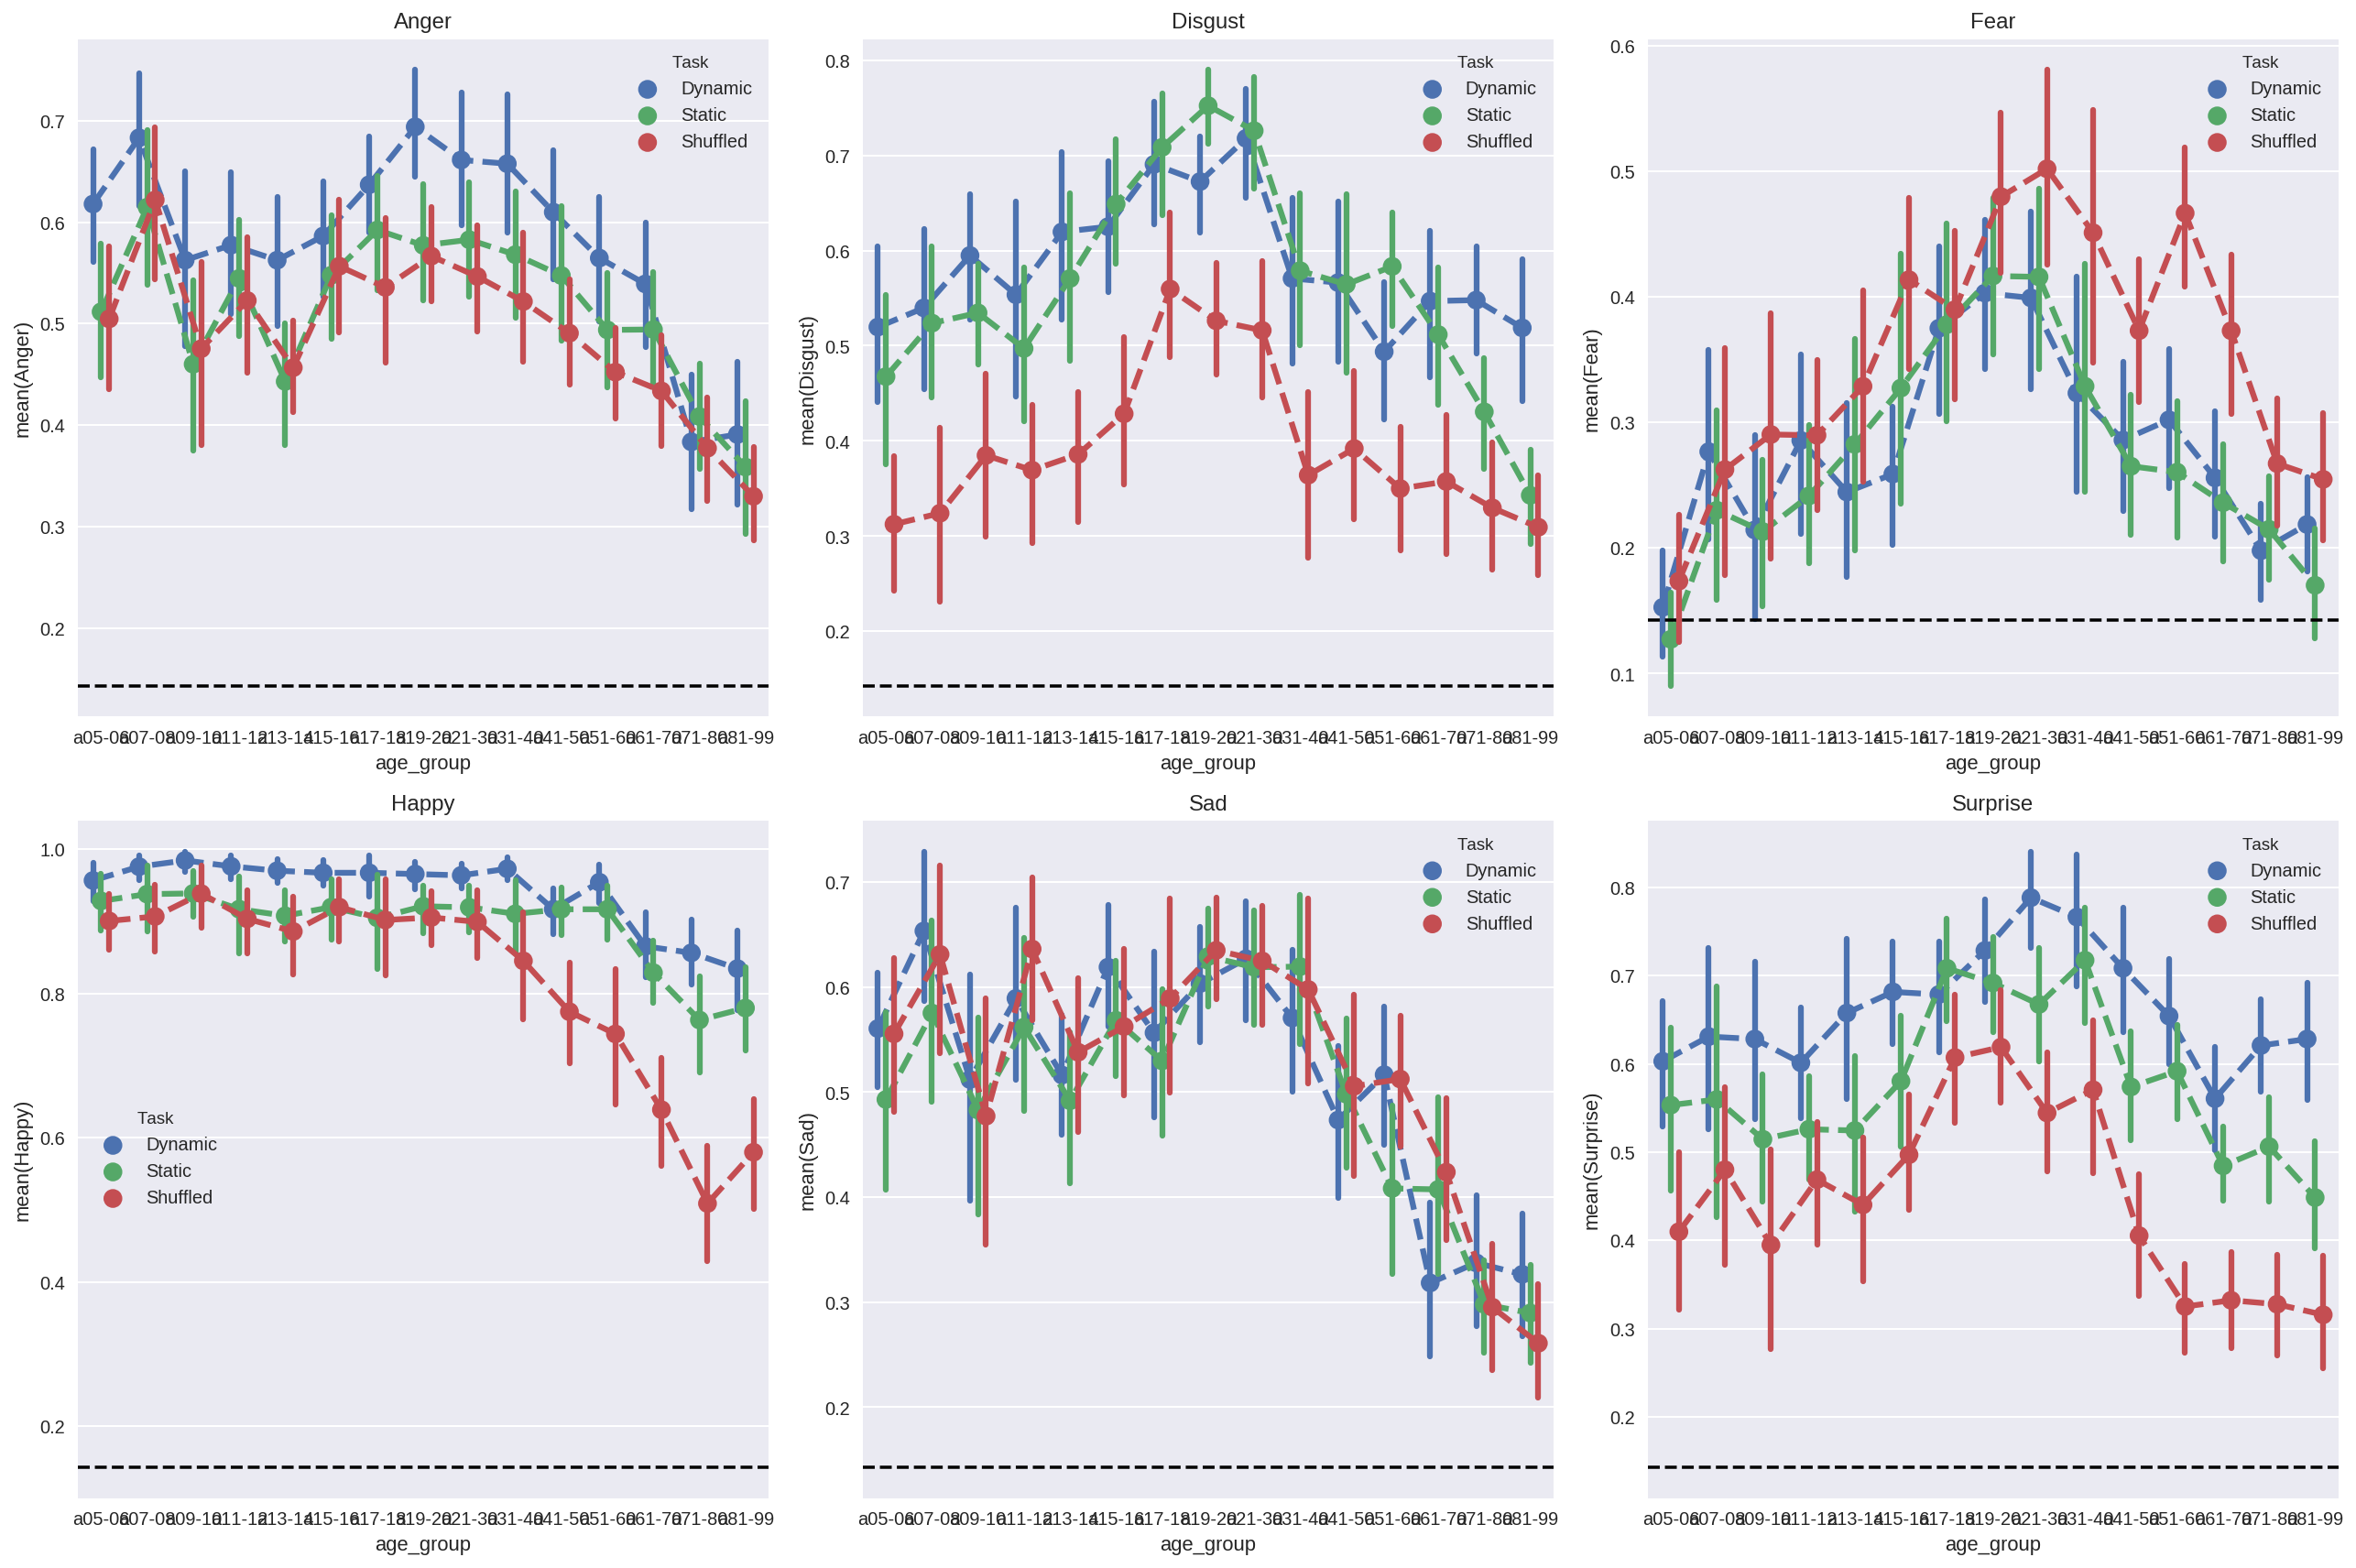

In [16]:
datatbl1['Task'] = 'Dynamic'
datatbl2['Task'] = 'Static'
datatbl3['Task'] = 'Shuffled'
datatbl_123 = pd.concat([datatbl1,datatbl2,datatbl3])

plt.figure(figsize=(18,12))
for ic, emolabel in enumerate(exp_list):
    ax = plt.subplot(2,3,ic+1)
    sns.pointplot(x="age_group", y=emolabel, hue='Task', dodge=.35, linestyles='--',
                  data=datatbl_123, estimator=np.mean, ci=95, n_boot=1000, ax=ax);
    ax.axhline(1/7,linestyle='--', color='k')
    plt.title(emolabel)
    
plt.tight_layout()
plt.show()

### Dynamic advantage as a function of age

Displaying difference: Dynamic - Static


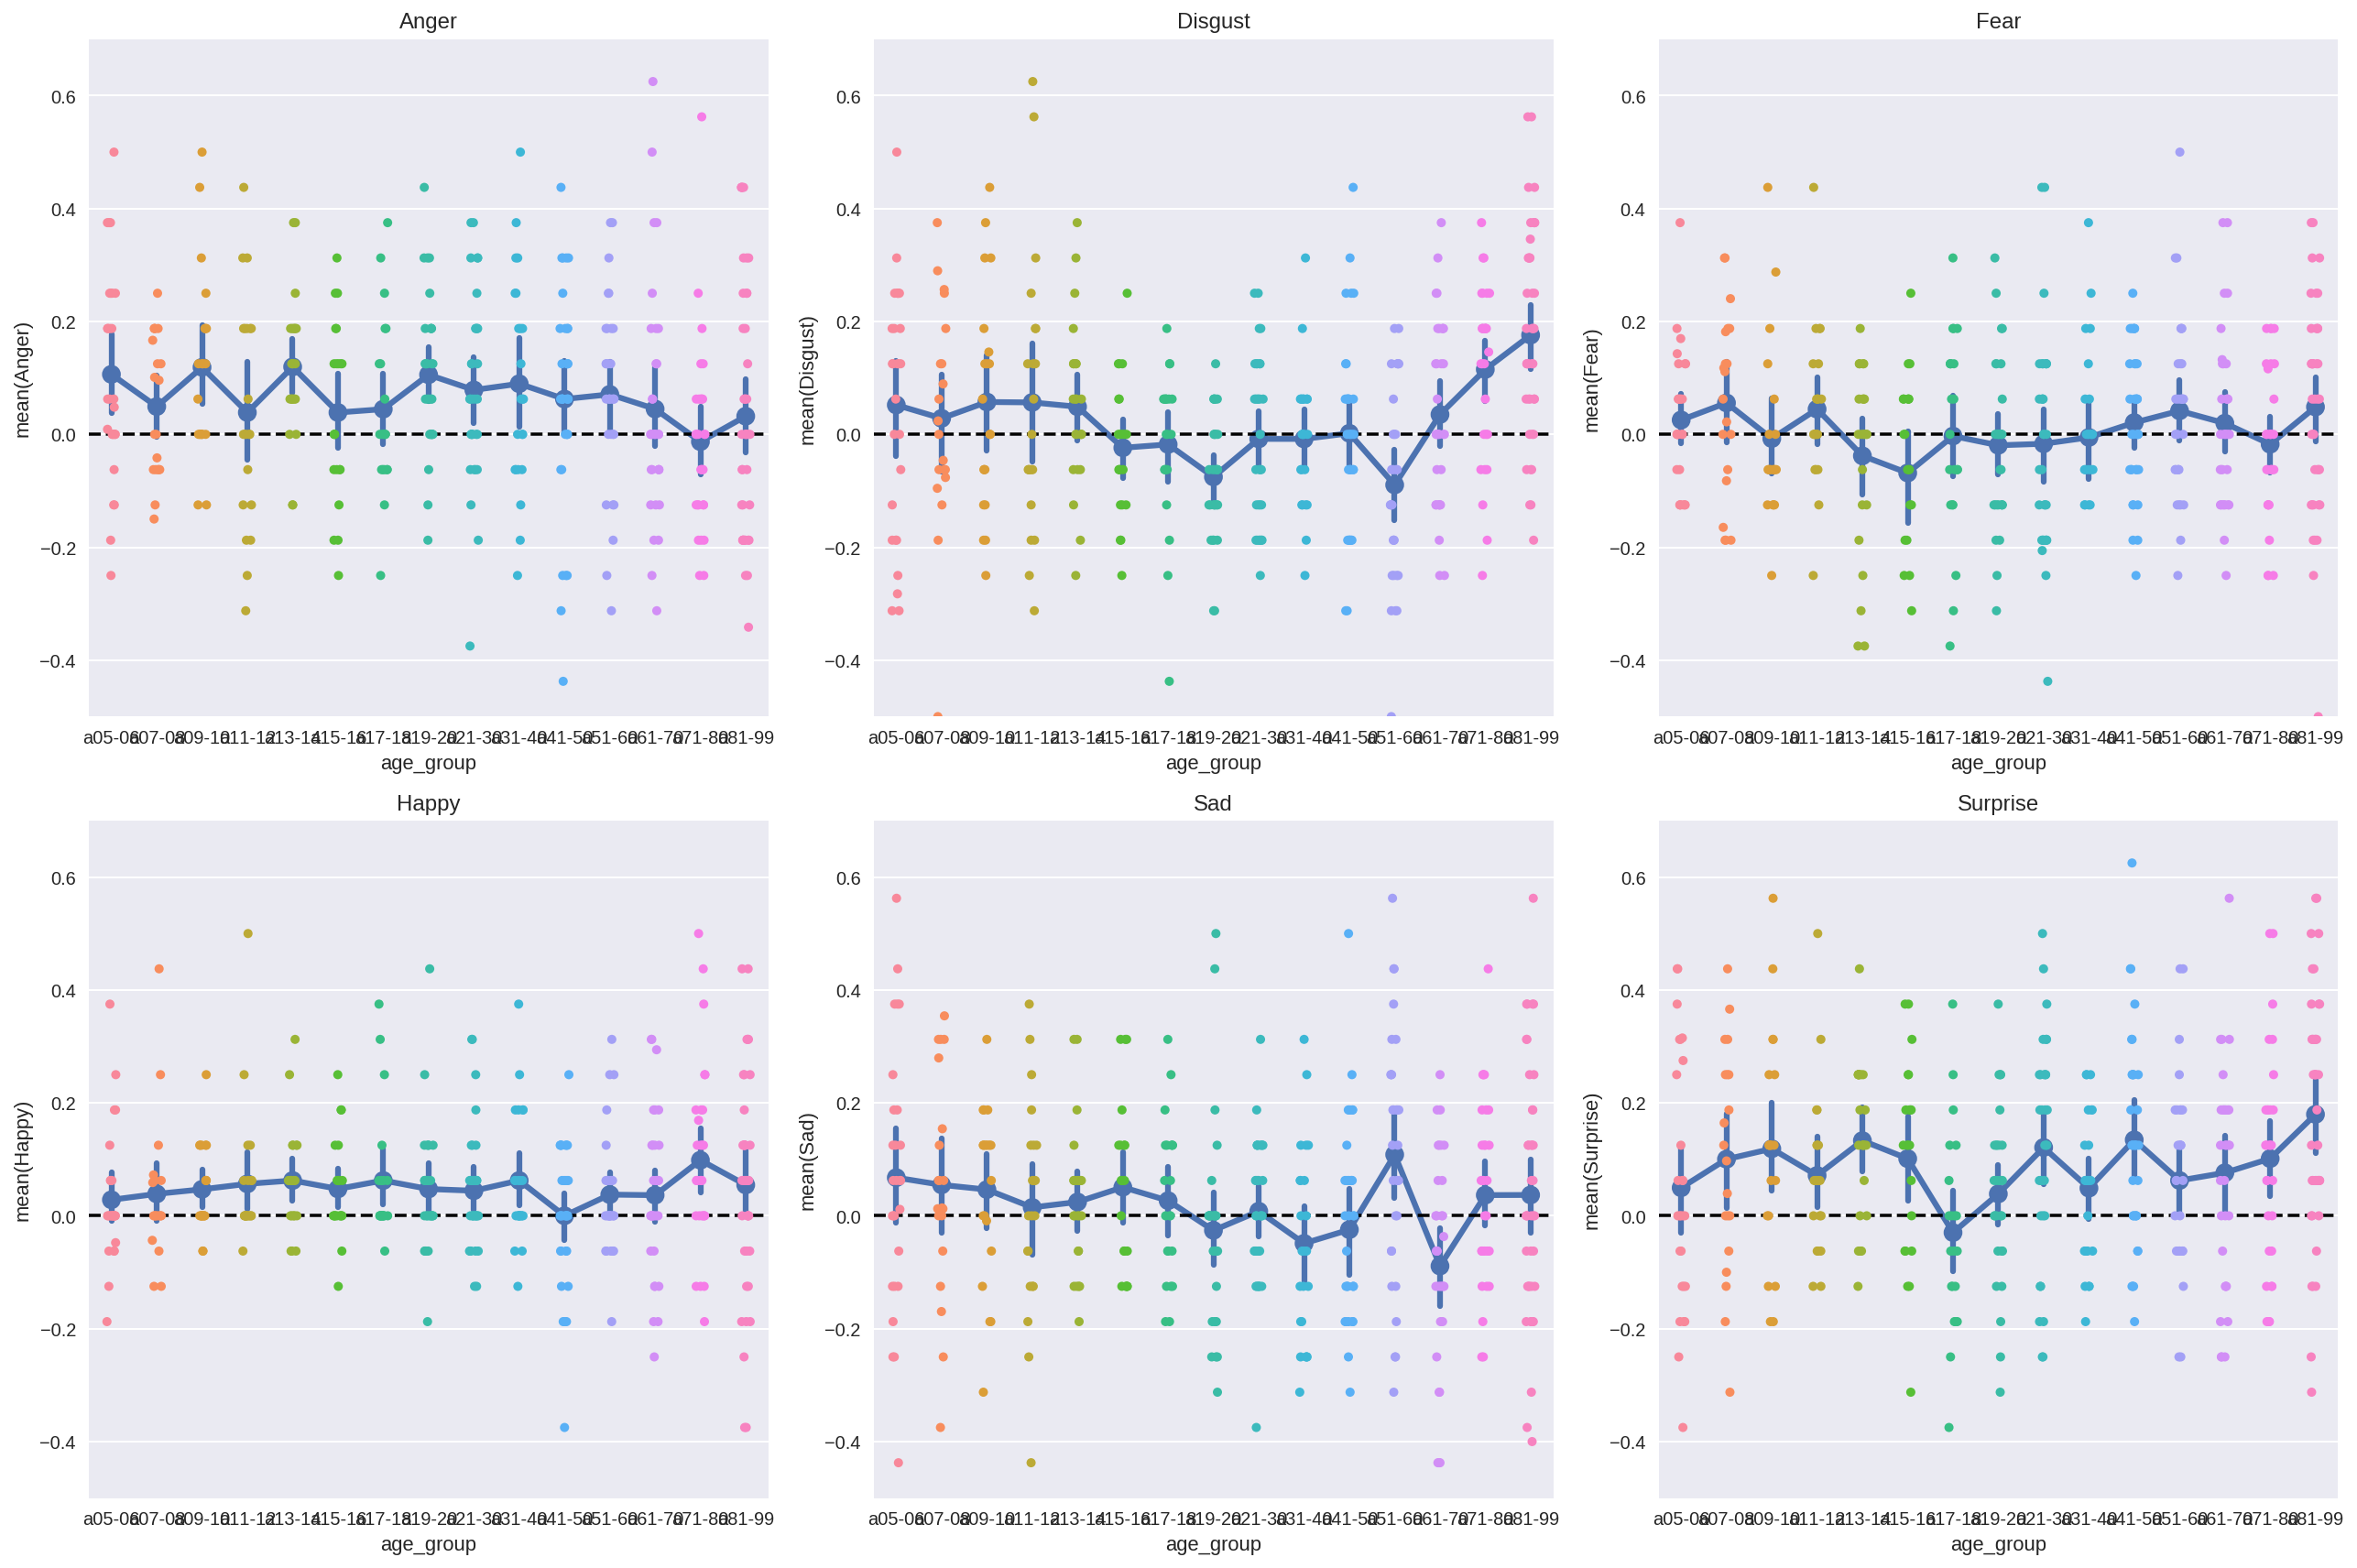

In [17]:
itask1 = 'Dynamic'
idx1 = np.where(Taskname == itask1)[0][0]
itask2 = 'Static'
idx2 = np.where(Taskname == itask2)[0][0]
mattmp  = Confmean[:,idx1,:,:]-Confmean[:,idx2,:,:]
print('Displaying difference: Dynamic - Static')

plt.figure(figsize=(18,12))
datatbl = pd.DataFrame.copy(Info_tbl)
for ic, emolabel in enumerate(exp_list):
    datatbl[emolabel] = mattmp[:,ic,ic]

    ax = plt.subplot(2,3,ic+1)
    sns.stripplot(x="age_group", y=emolabel, data=datatbl, jitter=True, ax=ax);
    sns.pointplot(x="age_group", y=emolabel, data=datatbl, estimator=np.mean, ci=95, n_boot=1000, ax=ax);
    ax.axhline(0,linestyle='--', color='k')
    plt.title(emolabel)
    plt.ylim([-.5,.7])
    #plt.ylim([-.2,.2])
    
plt.tight_layout()
plt.show()

### Display Raw

Displaying Dynamic condition
Displaying Static condition
Displaying Shuffled condition


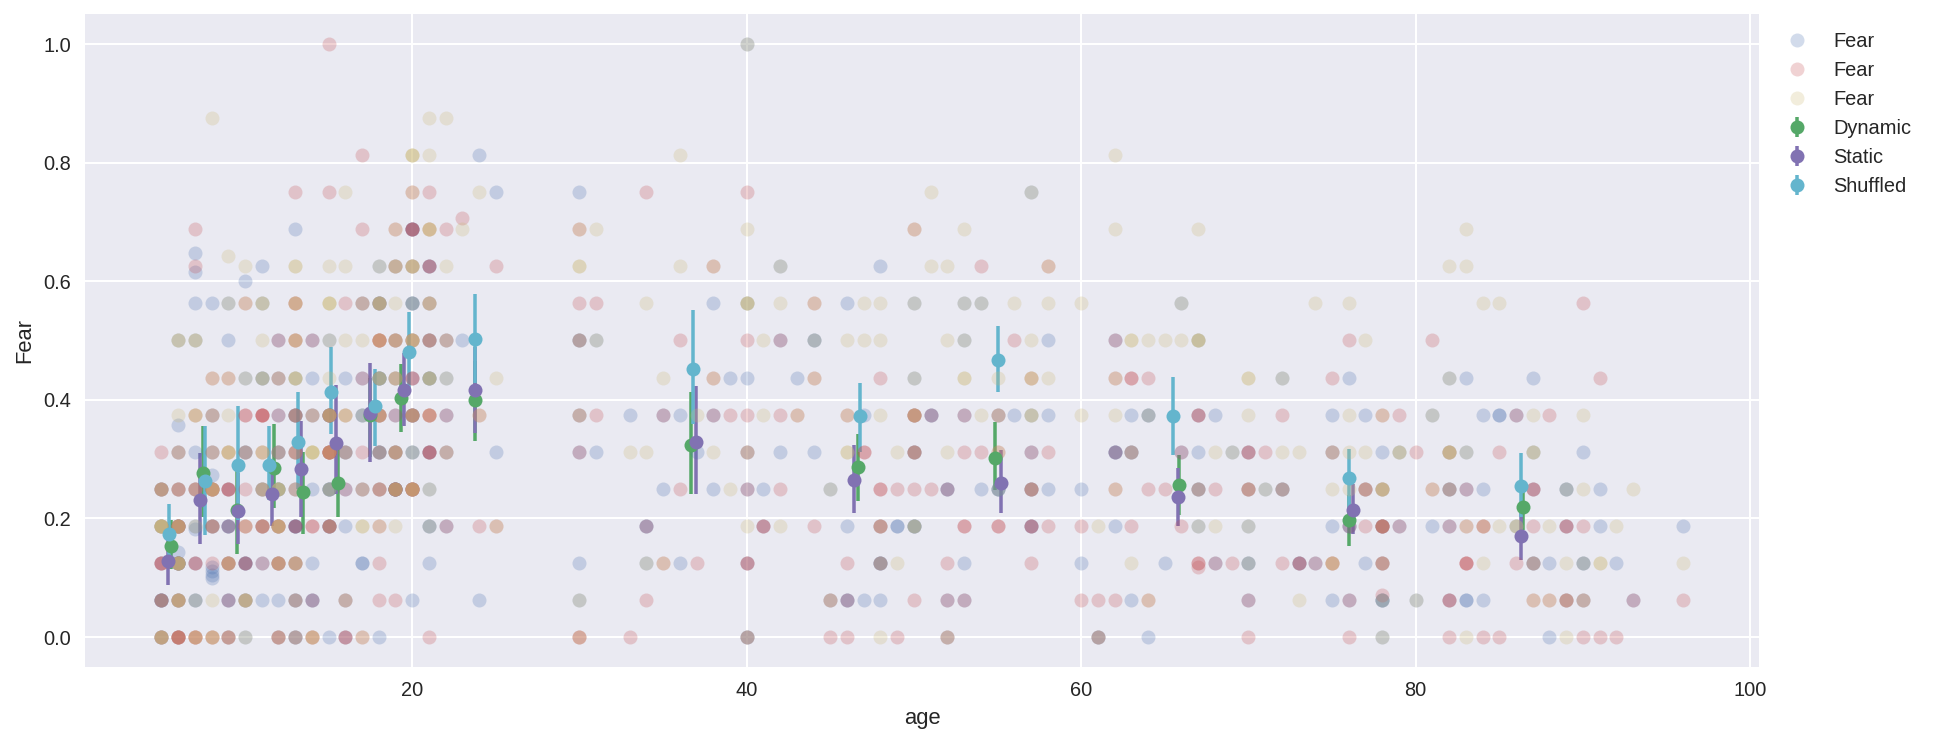

In [18]:
def plotraw(itask,emolabel,datatbl_123,ax):
    print('Displaying '+str(itask)+' condition')
    dftmp = datatbl_123.loc[datatbl_123['Task']==itask]
    ax.plot(dftmp['age'],dftmp[emolabel],'o',alpha=.25,label=emolabel)

    Nboot = 1000
    age_mean, acc_mean, acc_ci = [] , [] , []
    for iage in dftmp['age_mean'].unique():
        idex = dftmp['age_mean']==iage
        age_mean.append(iage)
        respvec = dftmp[emolabel][idex]
        meanvec = np.nanmean(np.random.choice(respvec,(len(respvec),Nboot)),axis=0)

        acc_mean.append(np.nanmean(respvec))
        acc_ci.append(np.percentile(meanvec,[2.5,97.5]))
    age_mean=np.asarray(age_mean)
    acc_mean=np.asarray(acc_mean)
    acc_ci=np.asarray(acc_ci)
    acc_ci[:,0]=acc_mean-acc_ci[:,0]
    acc_ci[:,1]=acc_ci[:,1]-acc_mean
    ax.errorbar(age_mean + (np.random.rand(age_mean.shape[0])-.5)*.5, acc_mean,
                yerr=acc_ci.transpose(), fmt='o', label=itask)
    
    ax.legend(loc=2, bbox_to_anchor=(1, 1))
    plt.ylabel(emolabel)
    plt.xlabel('age')
    
# itask  = 'Dynamic'
emolabel = 'Fear'
fig,ax= plt.subplots(1,1,figsize=(15,6))
for itask in ['Dynamic','Static','Shuffled']:
    plotraw(itask,emolabel,datatbl_123,ax=ax)

plt.show()

# Facial expression recognition as a function of age
We are interested in the dynamic advantage of facial expression, as displayed above, expression recognition accuracy follow a curve of first increase and then decrease. Moreover, some expression shows a general dynamic display advantage (i.e., higher accuracy in dynamic versus static condition). However, the question remains whether there is a stronger dynamic advantage when the biological system is a more fragile statue (i.e., in the early age when the system still developing, and in the later age when the system is in decline).

0.65 0.3


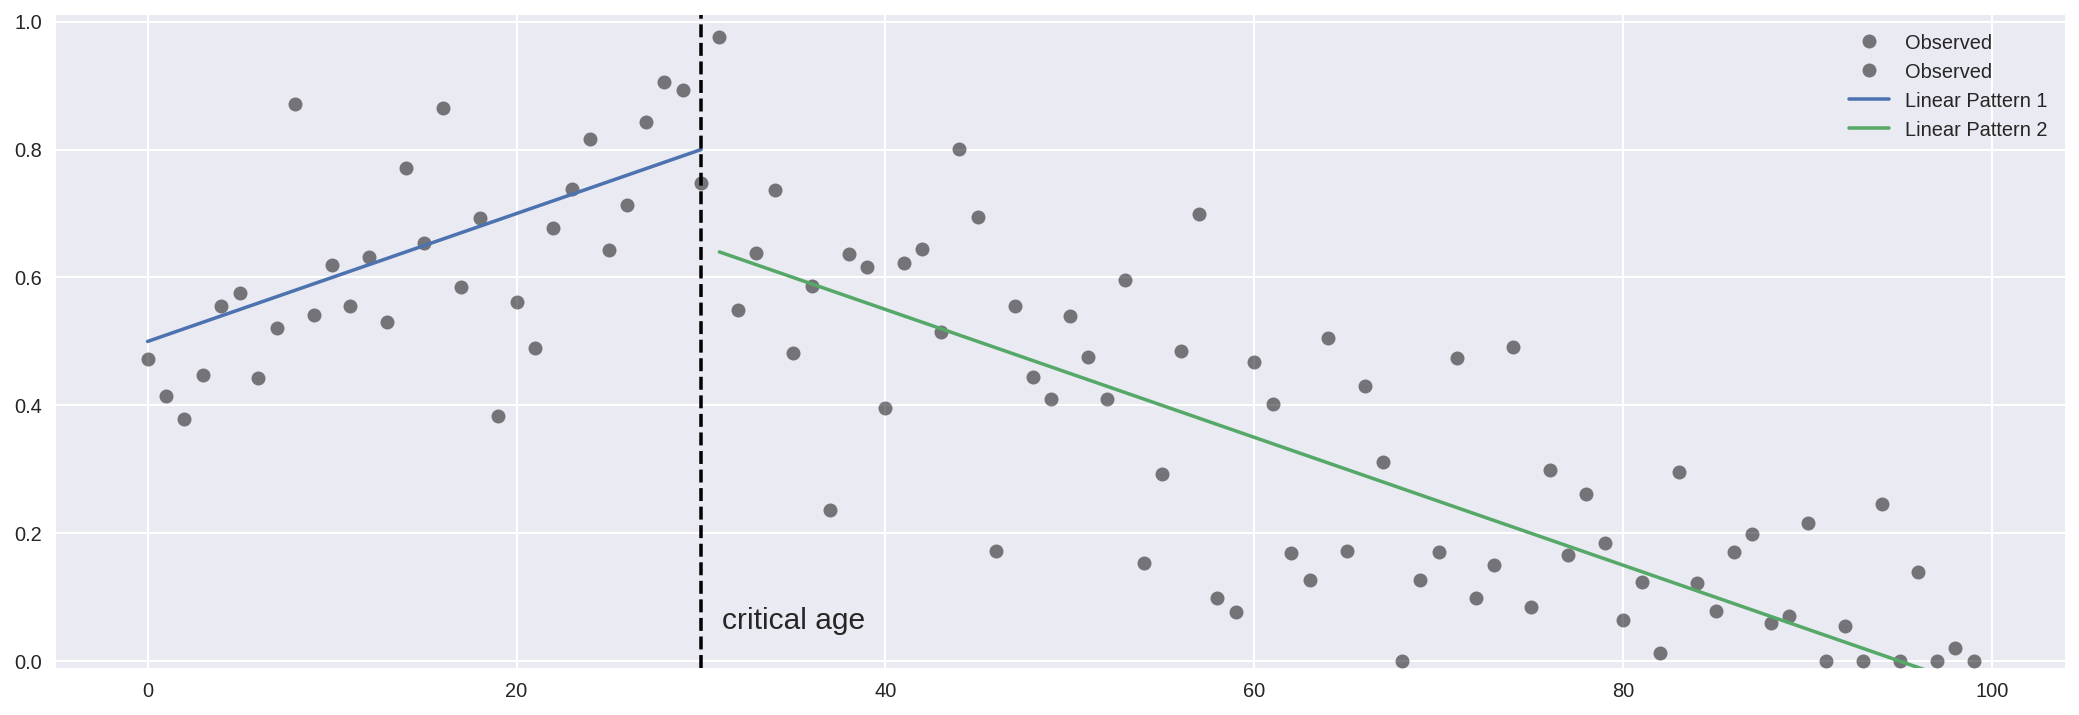

In [19]:
def emo_reg_model(intercept1,intercept2,critical_age,slope1,slope2,noise_level,
                  lmfunc=lambda intcept, delta, x: intcept + (delta*x)):
    '''
    critical_age: the onset age of cognitive decline
    intercept1: average recogtnition ability before the critical age
    intercept2: average recogtnition ability after the critical age
    slope1,slope2: linear function between age and recognition ability
    '''
    age1 = 0
    age2 = 100
    
    x1 = np.arange(age1,critical_age+1)
    y1 = lmfunc(intercept1,slope1,x1)
    noise1 = np.random.randn(len(x1))*noise_level
    x2 = np.arange(critical_age+1,age2)
    y2 = lmfunc(intercept2,slope2,x2) 
    noise2 = np.random.randn(len(x2))*noise_level
    
    y1real = np.clip(y1+noise1,0,1)
    y2real = np.clip(y2+noise2,0,1)
    print(y1.mean(),y2.mean())
    ax1=plt.plot(x1,y1real,'o',x2,y2real,'o',color='k',alpha=.5,label='Observed')
    ax2=plt.plot(x1,y1,label='Linear Pattern 1')
    ax3=plt.plot(x2,y2,label='Linear Pattern 2')
    plt.legend()
    plt.axvline(critical_age,linestyle='--', color='k')
    plt.text(critical_age+5, .05, r"critical age",
         horizontalalignment='center', fontsize=15)
    plt.ylim([-.01,1.01])

fig, ax = plt.subplots(1,1,figsize=(18,6))
emo_reg_model(.5,.95,30,0.01,-0.01,.15)

Formally, this is a [Piecewise Linear Regression Models](https://en.wikipedia.org/wiki/Piecewise_linear_function) (see [here](https://onlinecourses.science.psu.edu/stat501/node/310), and [here](http://datacolada.org/27) explaining why it is more appropreate than fitting a U-shape function expressed as high degree polynomial function). 
Here, we will express it as a Hierarchical Bayesian model and fitted in [PyMC3](https://github.com/pymc-devs/pymc3):


## Full model for fitting all task together
  
$i$ for each task (dynamic, static, shuffle), $j$ for each participant.

Hyperpriors for slope  
$$ \mu_{\beta} \sim \text{StudentT}(3, 0, 1)$$
$$ \sigma_{\beta} \sim \text{HalfNormal}(1)$$  

Turning point age as latent variable  
$$ \tau \sim \text{Uniform}(0, 100)$$
$$ \tau_{1}, \tau_{2}, \tau_{3}  \sim \text{Normal}(\tau, 10)$$  

Recognition ability at $\tau$ (reparameterized on the mode of $\text{Beta}$ )  
$$ \theta \sim \text{Uniform}(0, 1)$$
$$ \kappa \sim \text{Uniform}(0, Nt)$$
$$ \text{$a$} = \theta * (\kappa - 2) + 1$$
$$ \text{$b$} = (1 - \theta) * (\kappa - 2) + 1$$
$$ \theta_{1}, \theta_{2}, \theta_{3} \sim \text{Beta}(\text{$a$}, \text{$b$})$$  

The slopes
$$ \beta_{1}^{a,b}, \beta_{2}^{a,b}, \beta_{3}^{a,b} \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$$  

The intercepts
$$ b_{i}^{a,b} = logit(\theta_{i}) - \tau_{i}*\beta_{i}^{a,b} \text{ for $i \in {1,2,3}$} $$  

$$ \beta_{i}, \text{$Intercept$}_{i} =
\begin{cases}
\beta_{i}^{a}, b_{i}^{a}  & \text{if $age < \tau_{i}$} \\
\beta_{i}^{b}, b_{i}^{b}  & \text{if $age \geq \tau_{i}$}
\end{cases}  $$  

Linear function and invlogit
$$ \theta_{i,j} = \beta_{i} \otimes age_{j} + \text{$Intercept$}_{i}$$
$$ \hat{y}_{i,j} = \text{invlogit}(\theta_{i,j})$$

Observed
$$ \text{k}_{i,j} \sim \text{Binomial}(\hat{y}_{i,j}, \text{n}_{i,j})$$

### Setup helper function for PyMC3

In [20]:
def getdata(itask,emolabel,agevec='age'):
    idx1 = np.where(Taskname == itask)[0][0]
    mattmp  = Conf_mat[:,idx1,:,:]
    ic = np.where(exp_list == emolabel)[0][0]
    Resp   = mattmp[:,ic,ic].astype(int)
    trials = mattmp[:,ic,-1].astype(int)
    age    = np.asarray(Info_tbl[agevec])

    incld = (np.isfinite(Resp)) & (trials > 0)
    X = age[incld]
    Y = Resp[incld]
    T = trials[incld]
    return X,Y,T

def plotfitted(agemin,critical_age,agemax,beta,intercept,cc='r'):
    lmfunc = lambda x,b,c: 1/(1+np.exp(-(x*b+c)))
    x1 = np.linspace(agemin,critical_age,100)
    y1 = lmfunc(x1,beta[0],intercept[0])
    x2 = np.linspace(critical_age,agemax,100)
    y2 = lmfunc(x2,beta[1],intercept[1])
    plt.plot(x1,y1,x2,y2,label='linear fit',color=cc)
    plt.axvline(critical_age,linestyle='--', color='k')
    plt.ylim((-.05,1.05))

helper function of reading out from trace (both task modeling)

In [21]:
def plot_samplerstat(burnin,trace):
    # Sampler statistics
    accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
    print('The accept rate is: %.5f' % (accept.mean()))
    diverge = trace.get_sampler_stats('diverging')
    print('Diverge of the trace')
    print(diverge.nonzero())
    energy = trace['energy']
    energy_diff = np.diff(energy)
    sns.distplot(energy - energy.mean(), label='energy')
    sns.distplot(energy_diff, label='energy diff')
    plt.legend()
    plt.show()

def plot_selectposterior(burnin,trace):
    pm.plot_posterior(trace[burnin:],varnames=['beta1','beta2','beta3'],ref_val=0,color='#87ceeb')
    
    df_stmp = pm.df_summary(trace[burnin:],varnames=['tau'])
    trace_age = np.asarray(df_stmp['mean'])
    df_stmp = pm.df_summary(trace[burnin:],varnames=['tau1'])
    trace_age1 = np.asarray(df_stmp['mean'])
    df_stmp = pm.df_summary(trace[burnin:],varnames=['tau2'])
    trace_age2 = np.asarray(df_stmp['mean'])
    df_stmp = pm.df_summary(trace[burnin:],varnames=['tau3'])
    trace_age3 = np.asarray(df_stmp['mean'])
    
    df_stmp = pm.df_summary(trace[burnin:],varnames=['b1'])
    trace_intercept1 = np.asarray(df_stmp['mean'])
    df_stmp = pm.df_summary(trace[burnin:],varnames=['beta1'])
    trace_beta1 = np.asarray(df_stmp['mean'])
    
    df_stmp = pm.df_summary(trace[burnin:],varnames=['b2'])
    trace_intercept2 = np.asarray(df_stmp['mean'])
    df_stmp = pm.df_summary(trace[burnin:],varnames=['beta2'])
    trace_beta2 = np.asarray(df_stmp['mean'])
    
    df_stmp = pm.df_summary(trace[burnin:],varnames=['b3'])
    trace_intercept3 = np.asarray(df_stmp['mean'])
    df_stmp = pm.df_summary(trace[burnin:],varnames=['beta3'])
    trace_beta3 = np.asarray(df_stmp['mean'])

    fig,ax= plt.subplots(1,1,figsize=(15,6))
    for itask in ['Dynamic','Static','Shuffled']:
        plotraw(itask,emolabel,datatbl_123,ax=ax)

    plotfitted(agemin,trace_age1,agemax,trace_beta1,trace_intercept1,cc='green')
    plotfitted(agemin,trace_age2,agemax,trace_beta2,trace_intercept2,cc='purple')
    plotfitted(agemin,trace_age3,agemax,trace_beta3,trace_intercept3,cc='gray')
    ax.axvline(trace_age,linestyle='--', color='r')
    plt.text(trace_age+5, -.025, r"critical age",
             horizontalalignment='center', fontsize=15)

    pm.plot_posterior(trace[burnin:],varnames=['dync_stac','dync_shuf','shuf_stac'],
                      ref_val=0,color='#87ceeb')

    plt.show()
    
    dfall = pm.df_summary(trace[burnin:],varnames=['tau','tau1','tau2',
                                                   'beta1','beta2',
                                                   'dync_stac','dync_shuf','shuf_stac',
                                                   'dync_adv1','dync_adv2',
                                                   'shuf_adv1','shuf_adv2',
                                                   'dy_sh_adv1','dy_sh_adv2'])
    print(dfall)

In [26]:
agemin = Info_tbl['age'].min()
agemax = Info_tbl['age'].max()
emolabel = 'Anger'
Nsample=10000

X1,Y1,T1 = getdata('Dynamic',emolabel)
X2,Y2,T2 = getdata('Static',emolabel)
X3,Y3,T3 = getdata('Shuffled',emolabel)
agemin = X1.min()
agemax = X1.max()

Nt = 16 # number of trials by design
logitwithdiff = pm.Model()
with logitwithdiff:
    # Hyperpriors for slope
    mu_beta = pm.StudentT('mu_beta', nu=3, mu=0., sd=1.0)
    sigma_beta = pm.HalfNormal('sigma_beta', sd=1.0)

    # τ ∼ Uniform(0,100)
    tau = pm.Uniform('tau', lower=agemin, upper=agemax)
    tausigma = 10.
    tau1 = pm.Normal('tau1', mu=tau, sd=tausigma)
    tau2 = pm.Normal('tau2', mu=tau, sd=tausigma)
    tau3 = pm.Normal('tau3', mu=tau, sd=tausigma)

    # Recognition ability at τ 
    theta = pm.Uniform('theta', lower=0, upper=1)
    kappa_m2 = pm.Uniform('kappa',lower=0, upper=Nt-2)
    alpha = theta * kappa_m2 + 1
    beta = (1-theta) * kappa_m2 + 1
    thetak1 = pm.Beta('thetak1', alpha=alpha, beta=beta)
    thetak2 = pm.Beta('thetak2', alpha=alpha, beta=beta)
    thetak3 = pm.Beta('thetak3', alpha=alpha, beta=beta)

    # Model the slope
    beta1 = pm.Normal('beta1', mu=mu_beta, sd=sigma_beta, shape=2)
    beta2 = pm.Normal('beta2', mu=mu_beta, sd=sigma_beta, shape=2)
    beta3 = pm.Normal('beta3', mu=mu_beta, sd=sigma_beta, shape=2)
    # Model the intercept
    b1 = pm.Deterministic('b1', pm.math.logit(thetak1) - tau1*beta1)
    b2 = pm.Deterministic('b2', pm.math.logit(thetak2) - tau2*beta2)
    b3 = pm.Deterministic('b3', pm.math.logit(thetak3) - tau3*beta3)

    beta_vect1 = pm.math.switch(tau1 >= X1, beta1[0], beta1[1])
    beta_vect2 = pm.math.switch(tau2 >= X2, beta2[0], beta2[1])
    beta_vect3 = pm.math.switch(tau3 >= X3, beta3[0], beta3[1])
    b_vect1    = pm.math.switch(tau1 >= X1, b1[0], b1[1])
    b_vect2    = pm.math.switch(tau2 >= X2, b2[0], b2[1])
    b_vect3    = pm.math.switch(tau3 >= X3, b3[0], b3[1])

    # θ = β∗age + Intercept
    theta1 = beta_vect1 * X1 + b_vect1
    yhat1 = pm.math.invlogit(theta1)
    theta2 = beta_vect2 * X2 + b_vect2
    yhat2 = pm.math.invlogit(theta2)
    theta3 = beta_vect3 * X3 + b_vect3
    yhat3 = pm.math.invlogit(theta3)

    obs1 = pm.Binomial('obs1', p=yhat1, n=T1, observed=Y1)
    obs2 = pm.Binomial('obs2', p=yhat2, n=T2, observed=Y2)
    obs3 = pm.Binomial('obs3', p=yhat3, n=T3, observed=Y3)

    # differences of slope
    dync_stac = pm.Deterministic('dync_stac',beta1-beta2)
    dync_shuf = pm.Deterministic('dync_shuf',beta1-beta3)
    shuf_stac = pm.Deterministic('shuf_stac',beta3-beta2)

    # general dynamic advantage
    dync_adv1 = pm.Deterministic('dync_adv1',pm.math.invlogit(beta1[0]*(agemin+tau)/2+b1[0]) - 
                                             pm.math.invlogit(beta2[0]*(agemin+tau)/2+b2[0]))
    dync_adv2 = pm.Deterministic('dync_adv2',pm.math.invlogit(beta1[1]*(agemax+tau)/2+b1[1]) - 
                                             pm.math.invlogit(beta2[1]*(agemax+tau)/2+b2[1]))
    shuf_adv1 = pm.Deterministic('shuf_adv1',pm.math.invlogit(beta3[0]*(agemin+tau)/2+b3[0]) - 
                                             pm.math.invlogit(beta2[0]*(agemin+tau)/2+b2[0]))
    shuf_adv2 = pm.Deterministic('shuf_adv2',pm.math.invlogit(beta3[1]*(agemax+tau)/2+b3[1]) - 
                                             pm.math.invlogit(beta2[1]*(agemax+tau)/2+b2[1]))
    dy_sh_adv1 = pm.Deterministic('dy_sh_adv1',pm.math.invlogit(beta1[0]*(agemin+tau)/2+b1[0]) - 
                                            pm.math.invlogit(beta3[0]*(agemin+tau)/2+b3[0]))
    dy_sh_adv2 = pm.Deterministic('dy_sh_adv2',pm.math.invlogit(beta1[1]*(agemax+tau)/2+b1[1]) - 
                                            pm.math.invlogit(beta3[1]*(agemax+tau)/2+b3[1]))
    

In [30]:
advi=pm.advi
with logitwithdiff:
    v_params = advi(n=200000)
    start1 = pm.sample_vp(v_params, 1, progressbar=False)[0]
    cov1 = np.power(logitwithdiff.dict_to_array(v_params.stds), 2)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  This is separate from the ipykernel package so we can avoid doing imports until
Average ELBO = -60,023:  19%|█▉        | 38174/200000 [00:17<01:05, 2468.50it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -3,417.2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  after removing the cwd from sys.path.


In [34]:
njobs=1
with logitwithdiff:
    random_seed = int(np.atleast_1d(-1)[0])
    inference = pm.ADVI(model=logitwithdiff,seed=random_seed)
    approx = inference.fit(
                n=500000, 
                obj_optimizer=pm.adagrad,
                callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-2)],
                progressbar=True
                    )  # type: pm.MeanField
    start2 = approx.sample(draws=njobs)
    stds = approx.gbij.rmap(np.diag(approx.cov.eval()))
    cov2 = logitwithdiff.dict_to_array(stds)

Average Loss = 3,137.4: 100%|██████████| 500000/500000 [04:51<00:00, 1714.59it/s]   
Finished [100%]: Average Loss = 3,137.4


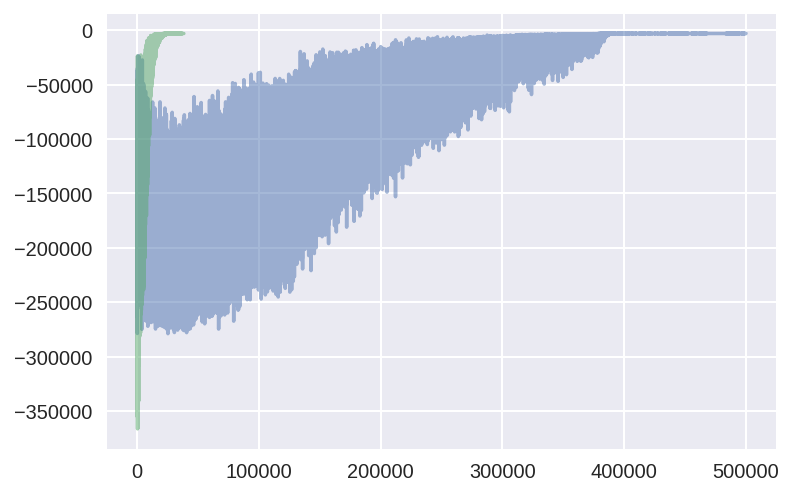

In [35]:
plt.plot(-inference.hist, alpha=.5)
plt.plot(v_params.elbo_vals, alpha=.5)
plt.show()

In [46]:
cov = cov1
start = start1
with logitwithdiff:
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace = pm.sample(3000, njobs=2, step=step, start=start, tune=1000)

100%|██████████| 3000/3000 [02:04<00:00, 24.02it/s]


In [ ]:
cov = cov2
start = start2[0]
with logitwithdiff:
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace = pm.sample(3000, njobs=2, step=step, start=start, tune=1000)

### Anger

In [ ]:
pm.traceplot(trace, varnames=['tau1','tau2','tau3','beta1','b1','beta2','b2','beta3','b3',
                                  'dync_stac','dync_shuf','shuf_stac']);

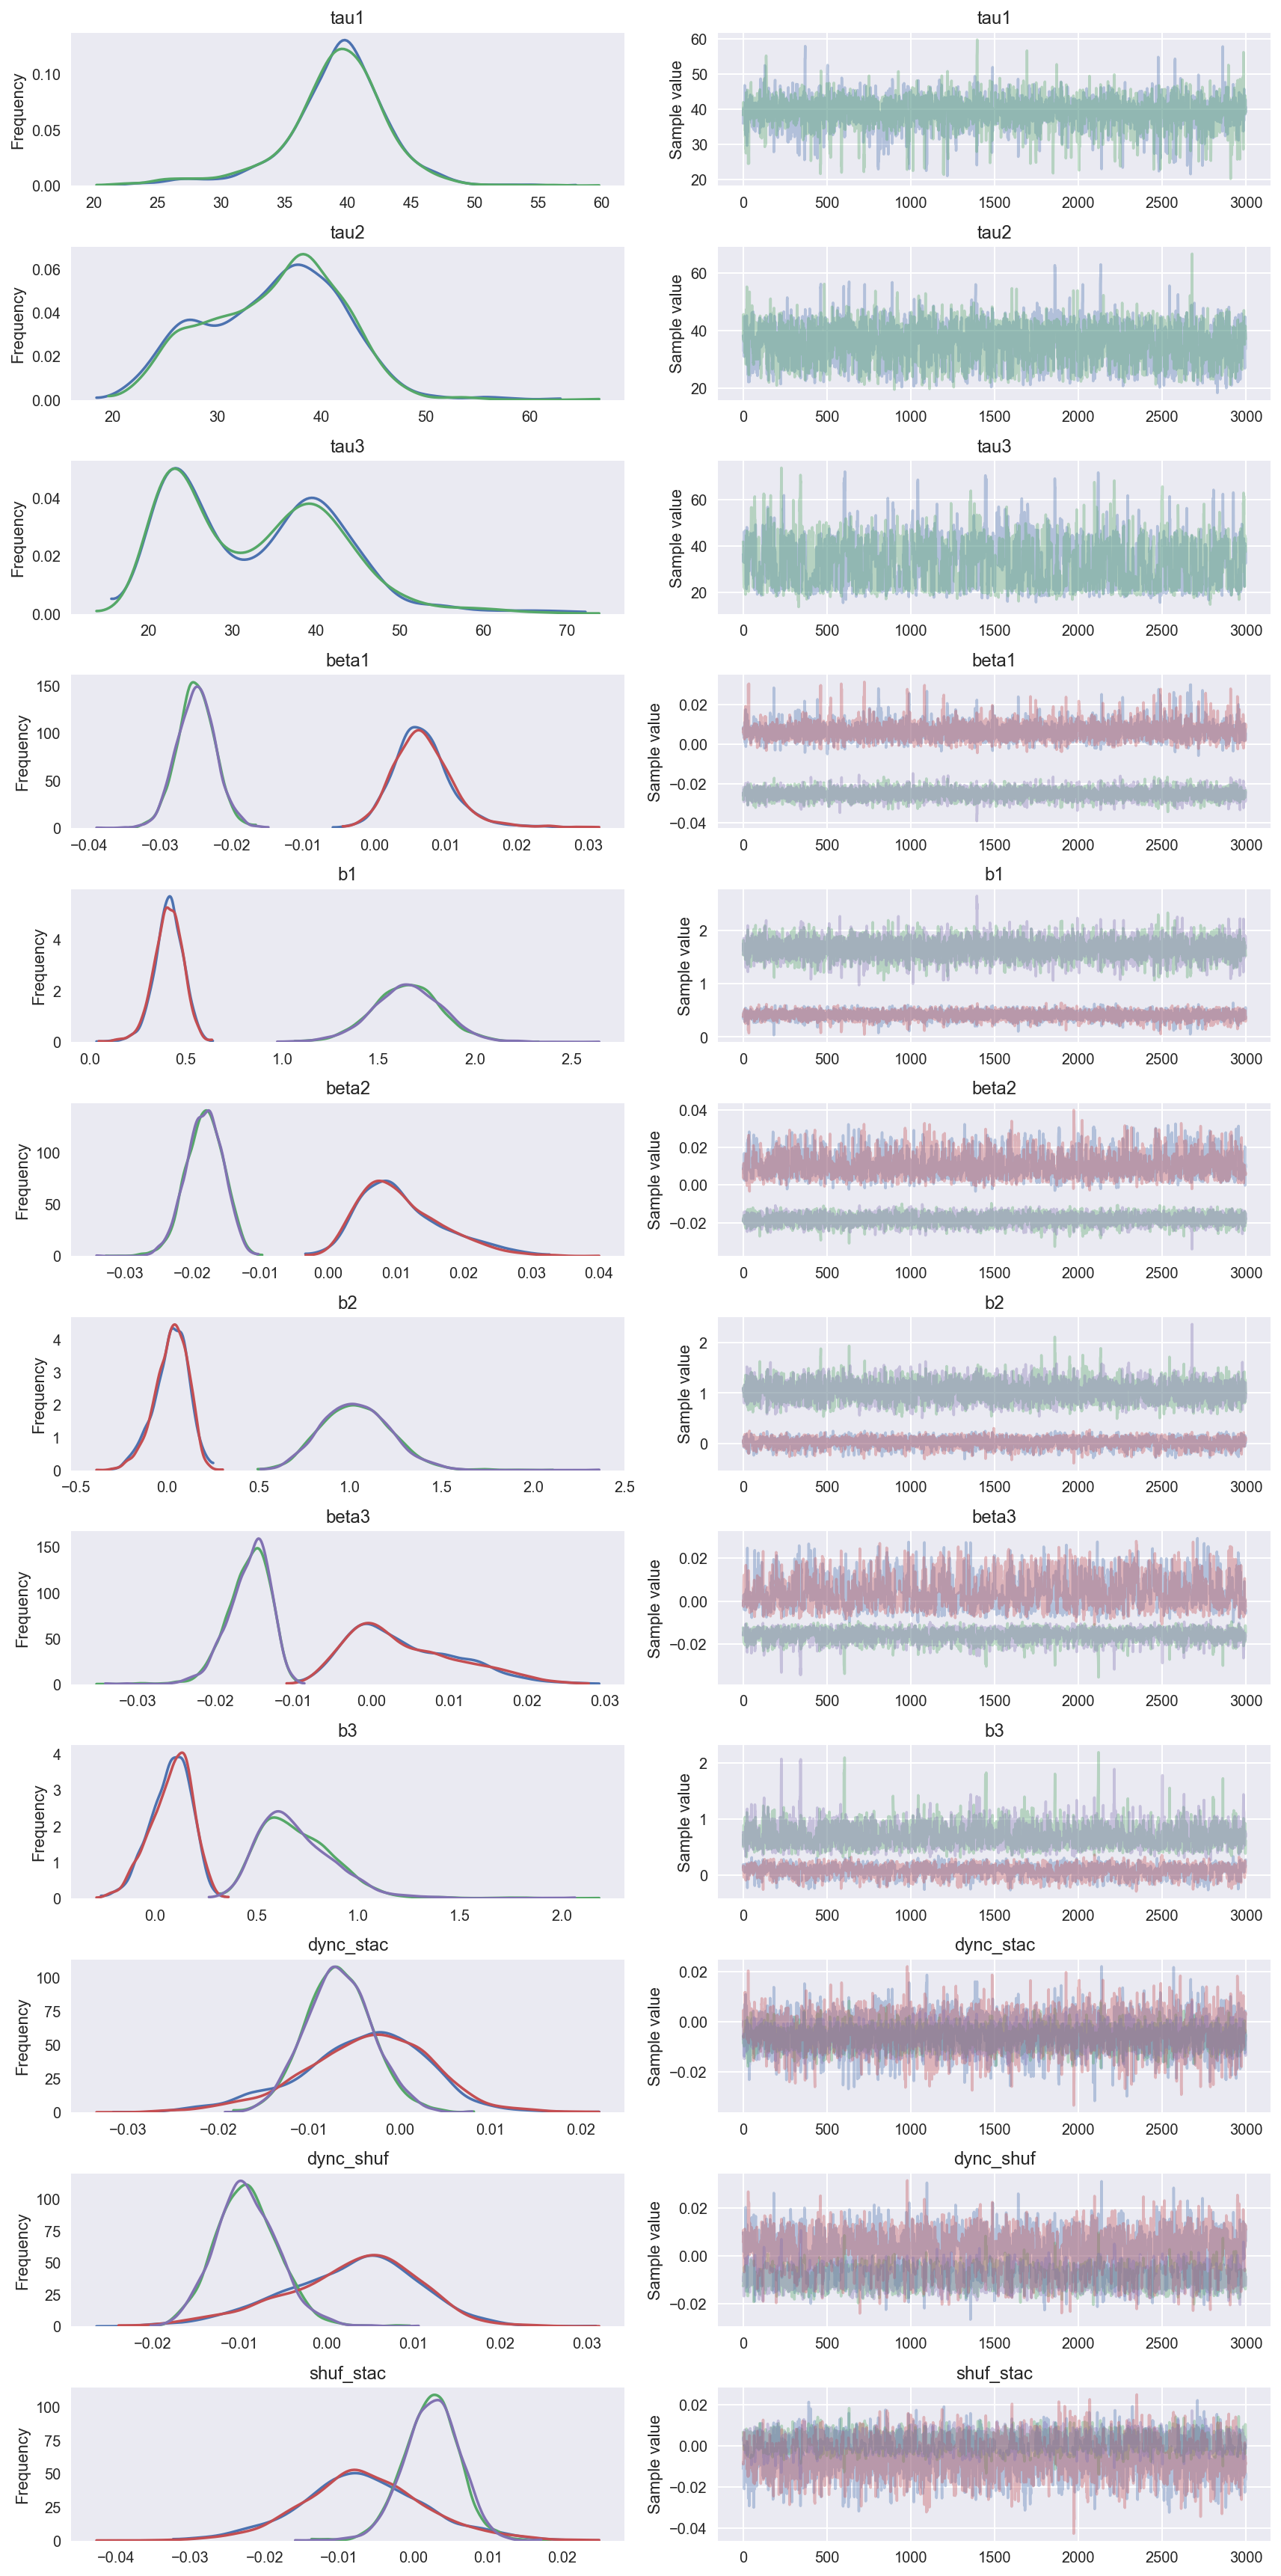

In [47]:
pm.traceplot(trace, varnames=['tau1','tau2','tau3','beta1','b1','beta2','b2','beta3','b3',
                                  'dync_stac','dync_shuf','shuf_stac']);

The accept rate is: 0.79962
Diverge of the trace
(array([  1, 134]),)


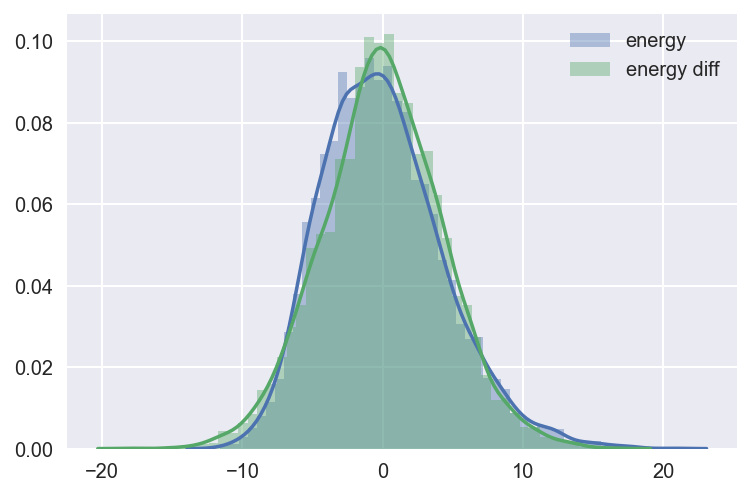

In [36]:
plot_samplerstat(burnin=1000,trace=trace);

Displaying Dynamic condition
Displaying Static condition
Displaying Shuffled condition


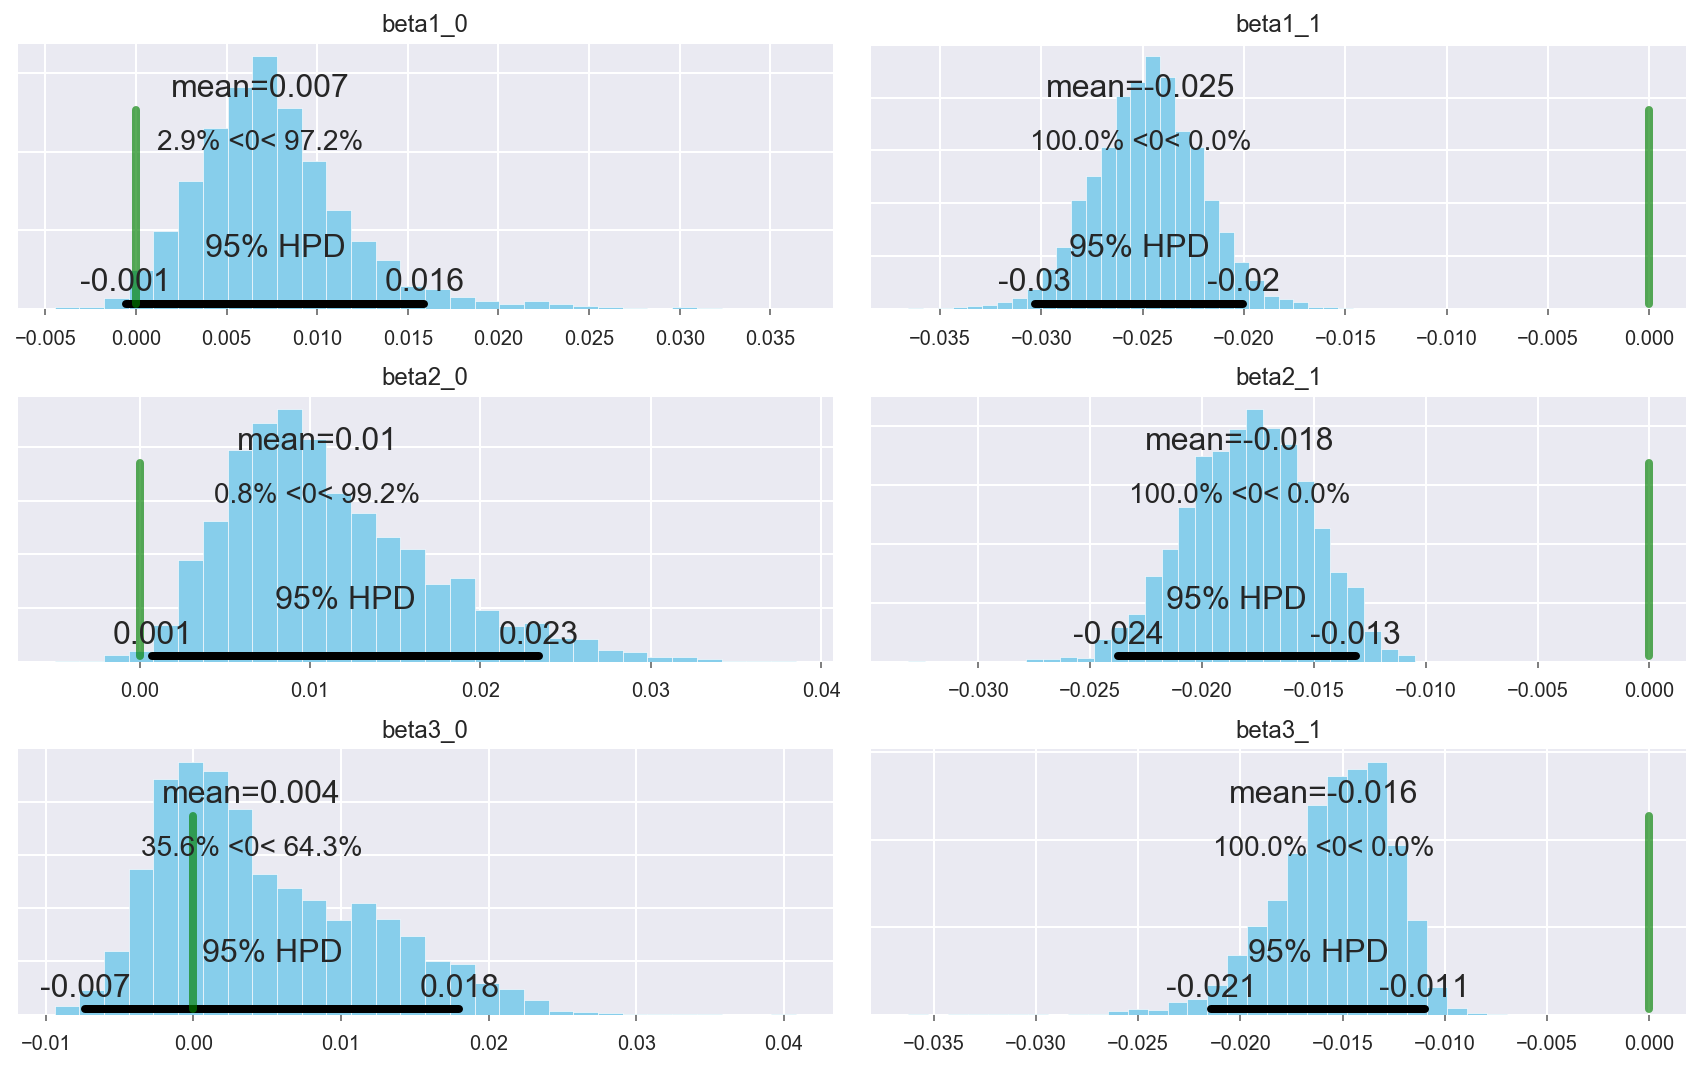

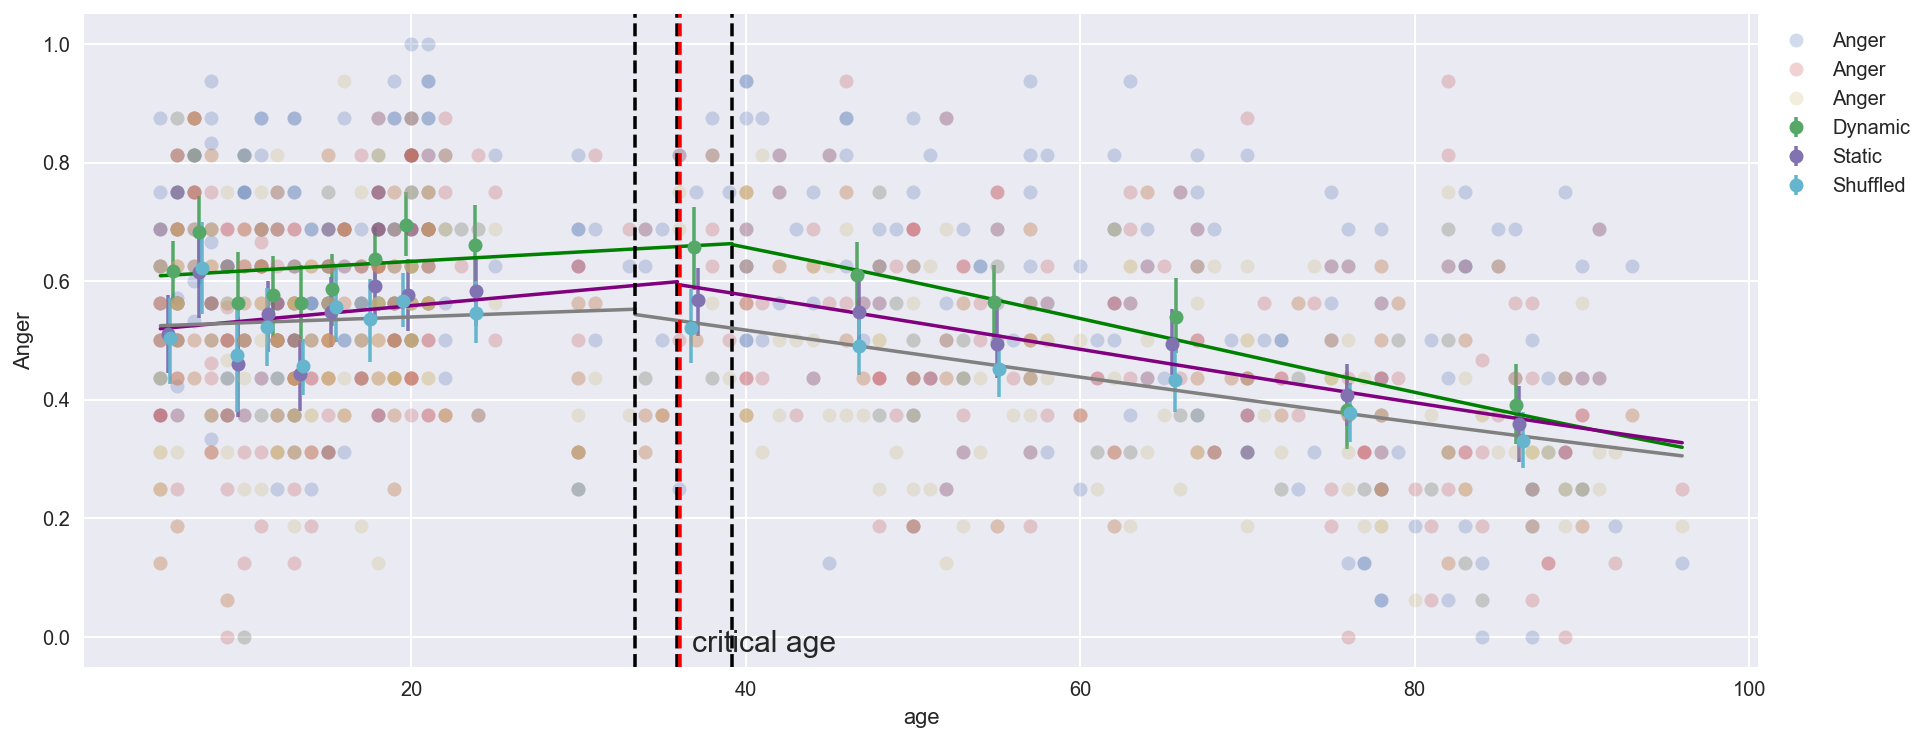

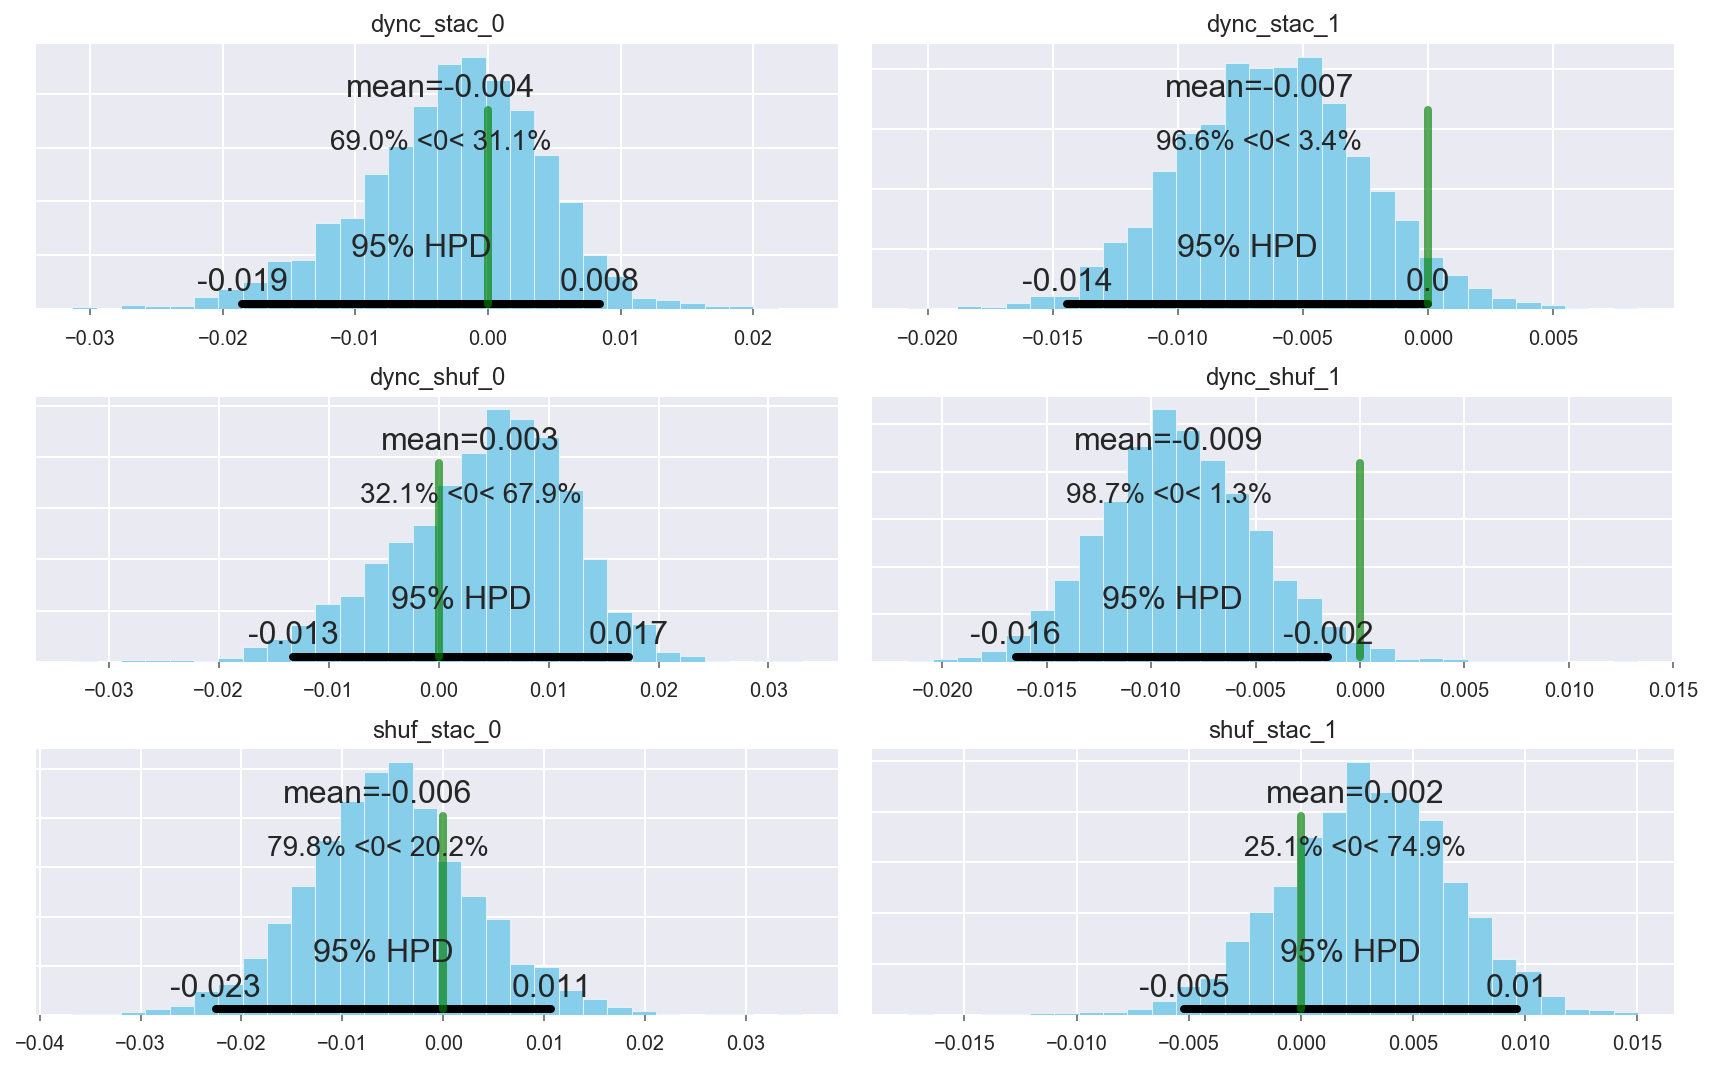

                   mean        sd  mc_error    hpd_2.5   hpd_97.5
tau           36.070515  7.462015  0.174958  22.090051  51.292847
tau1          39.189486  4.008587  0.095911  31.319329  47.831067
tau2          35.921767  6.238779  0.154144  24.113959  46.477995
beta1__0       0.006855  0.004394  0.000106  -0.000571   0.015915
beta1__1      -0.025081  0.002634  0.000047  -0.030329  -0.020037
beta2__0       0.010426  0.006093  0.000167   0.000750   0.023437
beta2__1      -0.018331  0.002781  0.000047  -0.023756  -0.013135
dync_stac__0  -0.003571  0.006943  0.000179  -0.018537   0.008429
dync_stac__1  -0.006750  0.003707  0.000062  -0.014427   0.000009
dync_shuf__0   0.002924  0.007876  0.000250  -0.013217   0.017297
dync_shuf__1  -0.009155  0.003845  0.000087  -0.016485  -0.001524
shuf_stac__0  -0.006495  0.008363  0.000229  -0.022565   0.010726
shuf_stac__1   0.002405  0.003808  0.000066  -0.005198   0.009623
dync_adv1      0.075219  0.015489  0.000310   0.042685   0.103982
dync_adv2 

In [37]:
plot_selectposterior(burnin=1000,trace=trace)

In [53]:
pm.diagnostics.effective_n(trace[1000:])

{'b1': array([ 1898.,  2566.]),
 'b2': array([ 1286.,  2181.]),
 'b3': array([  684.,  1236.]),
 'beta1': array([ 1367.,  2685.]),
 'beta2': array([  959.,  2006.]),
 'beta3': array([  553.,  1372.]),
 'dy_sh_adv1': 819.0,
 'dy_sh_adv2': 2141.0,
 'dync_adv1': 1767.0,
 'dync_adv2': 2827.0,
 'dync_shuf': array([  732.,  2207.]),
 'dync_stac': array([ 1189.,  2564.]),
 'kappa': 2532.0,
 'kappa_interval__': 2759.0,
 'mu_beta': 2275.0,
 'shuf_adv1': 890.0,
 'shuf_adv2': 3269.0,
 'shuf_stac': array([  771.,  2020.]),
 'sigma_beta': 1692.0,
 'sigma_beta_log__': 1711.0,
 'tau': 1083.0,
 'tau1': 1524.0,
 'tau2': 1050.0,
 'tau3': 528.0,
 'tau_interval__': 1043.0,
 'theta': 2942.0,
 'theta_interval__': 2461.0,
 'thetak1': 2197.0,
 'thetak1_logodds__': 2173.0,
 'thetak2': 1426.0,
 'thetak2_logodds__': 1428.0,
 'thetak3': 562.0,
 'thetak3_logodds__': 562.0}

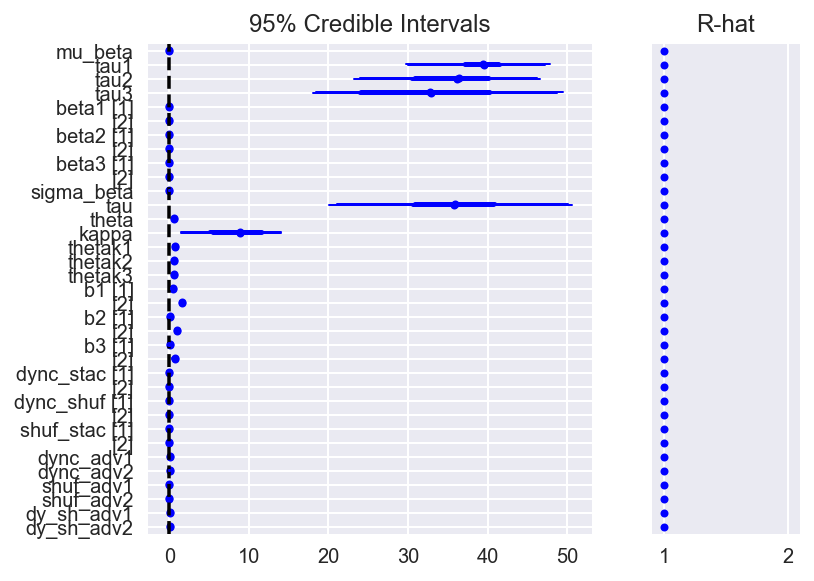

In [55]:
pm.forestplot(trace);